# Geospatial Earthquake Analysis and Machine Learning Project

### Connor McManigal

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [3]:
# earthquake dataset (https://www.kaggle.com/datasets/shreyasur965/recent-earthquakes/data)
df = pd.read_csv("~/Desktop/GeoSpatial/data/earthquakes.csv")
usa = df[df['country'] == 'United States of America (the)']
print(df.shape)
print(usa.shape)
print(df.columns)

(1137, 43)
(423, 43)
Index(['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url',
       'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place',
       'distanceKM', 'placeOnly', 'location', 'continent', 'country',
       'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone',
       'locationDetails'],
      dtype='object')


In [4]:
# fill in missing state info
usa.loc[usa['subnational'].isna() & usa['title'].str.contains('CA'), 'subnational'] = 'California'

In [5]:
df['tsunami'].value_counts()

tsunami
0    1069
1      68
Name: count, dtype: int64

In [6]:
# proportion of earthquakes that create tsunamis
(df[df['tsunami'] == 1].shape[0]) / (df[df['tsunami'] == 0].shape[0])

0.06361085126286249

In [7]:
print(" Earthquakes from", df['date'].min(), " to ", df['date'].max())

 Earthquakes from 2023-06-23T17:39:13  to  2024-09-18T12:02:12


## EDA

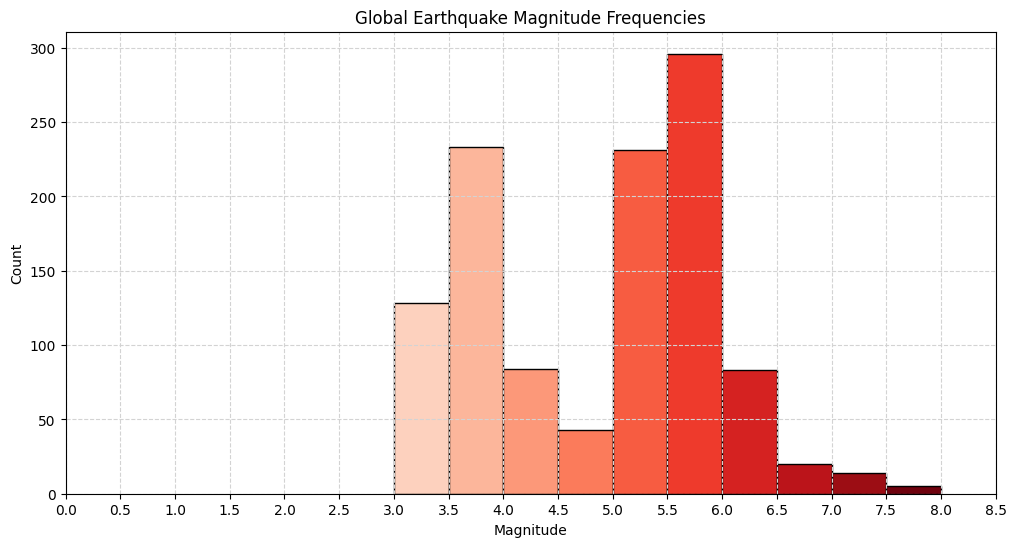

In [8]:
# histogram of magnitudes
min_mag = df['magnitude'].min()
max_mag = df['magnitude'].max()
bins = np.arange(min_mag, max_mag + 0.5, 0.5)

plt.figure(figsize = (12,6))
n, bins, patches = plt.hist(df['magnitude'], edgecolor = 'black', bins = bins)
normalized = plt.Normalize(min_mag - 1, max_mag)
cmap = plt.cm.Reds
for bin, patch in zip(bins, patches):
    color = cmap(normalized(bin))
    patch.set_facecolor(color)

plt.title('Global Earthquake Magnitude Frequencies')
plt.xlabel("Magnitude")
plt.ylabel('Count')
plt.xticks(np.arange(0,9,0.5))
plt.grid(True, linestyle='--', color='lightgrey')
plt.show()

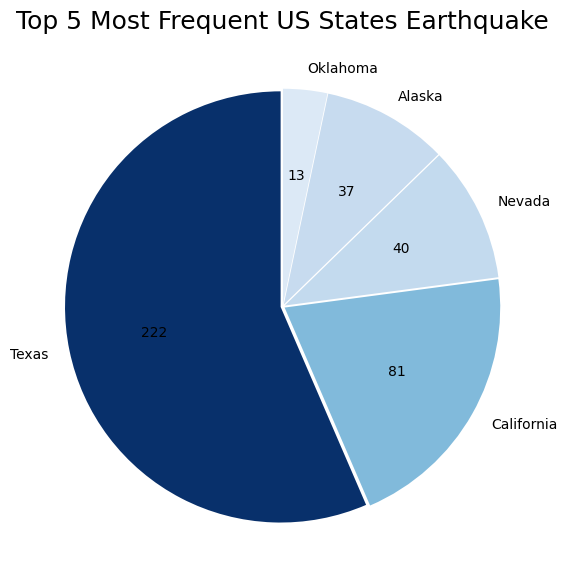

In [9]:
# function for calculating pie chart counts
def func(pct, allvalues):
    absolute = int(round(pct / 100. * sum(allvalues)))  # Calculate the absolute count
    return f'{absolute}'

us_places = usa['subnational'].value_counts()
top_5 = us_places.head(5)
norm = plt.Normalize(top_5.min()-30 , top_5.max()-20)
colors = plt.cm.Blues(norm(top_5.values))
explode = [0.01] * len(top_5)

plt.figure(figsize = (7, 7))
plt.pie(top_5, labels = top_5.index, startangle = 90, colors = colors, autopct = lambda pct: func(pct, top_5.values), explode = explode, labeldistance = 1.1, textprops={'fontsize': 10})
plt.title('Top 5 Most Frequent US States Earthquake', fontsize = 18)
plt.show()

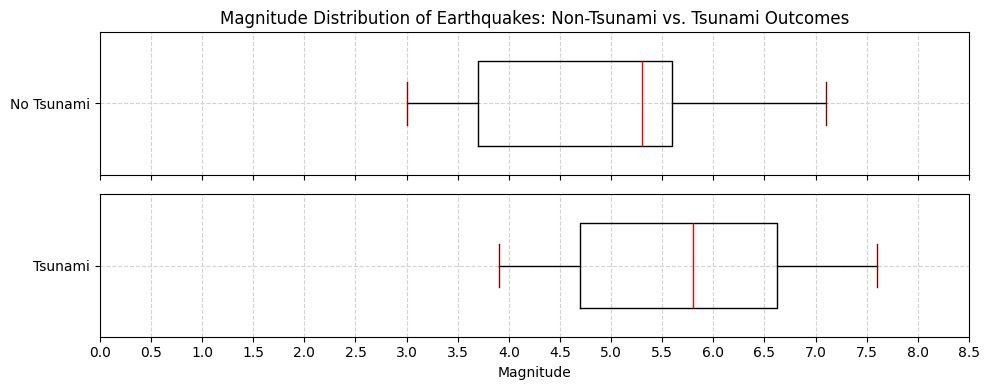

In [10]:
# distribution of earthquake magnitudes causing tsunamis versus those that didn't
tsu = df[df['tsunami'] == 1]
notsu = df[df['tsunami'] != 1]

fig, axes = plt.subplots(2, 1, figsize = (10,4), sharex = True)

axes[0].boxplot(notsu['magnitude'], vert = False, widths = 0.6, capprops = dict(color='darkred'), medianprops = dict(color='red'))
axes[0].set_title('Magnitude Distribution of Earthquakes: Non-Tsunami vs. Tsunami Outcomes')
axes[0].grid(True, linestyle = '--', color = 'lightgrey')
axes[0].set_yticks([1])
axes[0].set_yticklabels(['No Tsunami'])
axes[0].set_xticks(np.arange(0,9,0.5))

axes[1].boxplot(tsu['magnitude'], vert = False, widths = 0.6, capprops = dict(color='darkred'), medianprops = dict(color='red'))
axes[1].set_xlabel('Magnitude')
axes[1].set_yticks([1])
axes[1].set_yticklabels(['Tsunami'])
axes[1].grid(True, linestyle = '--', color = 'lightgrey')
axes[1].set_xticks(np.arange(0,9,0.5))

plt.tight_layout()
plt.show()

## Visualizing US Earthquakes

In [11]:
# convert us data to geoDF and handle missingness
usa = gpd.GeoDataFrame(usa, geometry = gpd.points_from_xy(usa['longitude'], usa['latitude'], crs = "EPSG:4269"))
usa.loc[usa['subnational'].isna() & usa['title'].str.contains('CA'), 'subnational'] = 'California'

# state shape files (https://www2.census.gov/geo/tiger/TIGER2024/)
states = gpd.read_file("~/Desktop/GeoSpatial/data/tl_2024_us_state/tl_2024_us_state.shp")

# merged (USA/states) files for density plotting
merged = gpd.sjoin(usa, states, how = 'inner', predicate = 'intersects')

# faults map (https://www.usgs.gov/programs/earthquake-hazards/faults)
faults = gpd.read_file("~/Desktop/GeoSpatial/data/Qfaults_GIS/SHP/Qfaults_US_Database.shp")
faults = faults.to_crs("EPSG:4269")

In [12]:
# ensure all files use coordinate reference systems that are the same
print("USA CRS:", usa.crs)
print("States CRS:", states.crs)
print("Merged CRS:", merged.crs)
print("Faults CRS:", faults.crs)

USA CRS: EPSG:4269
States CRS: EPSG:4269
Merged CRS: EPSG:4269
Faults CRS: EPSG:4269


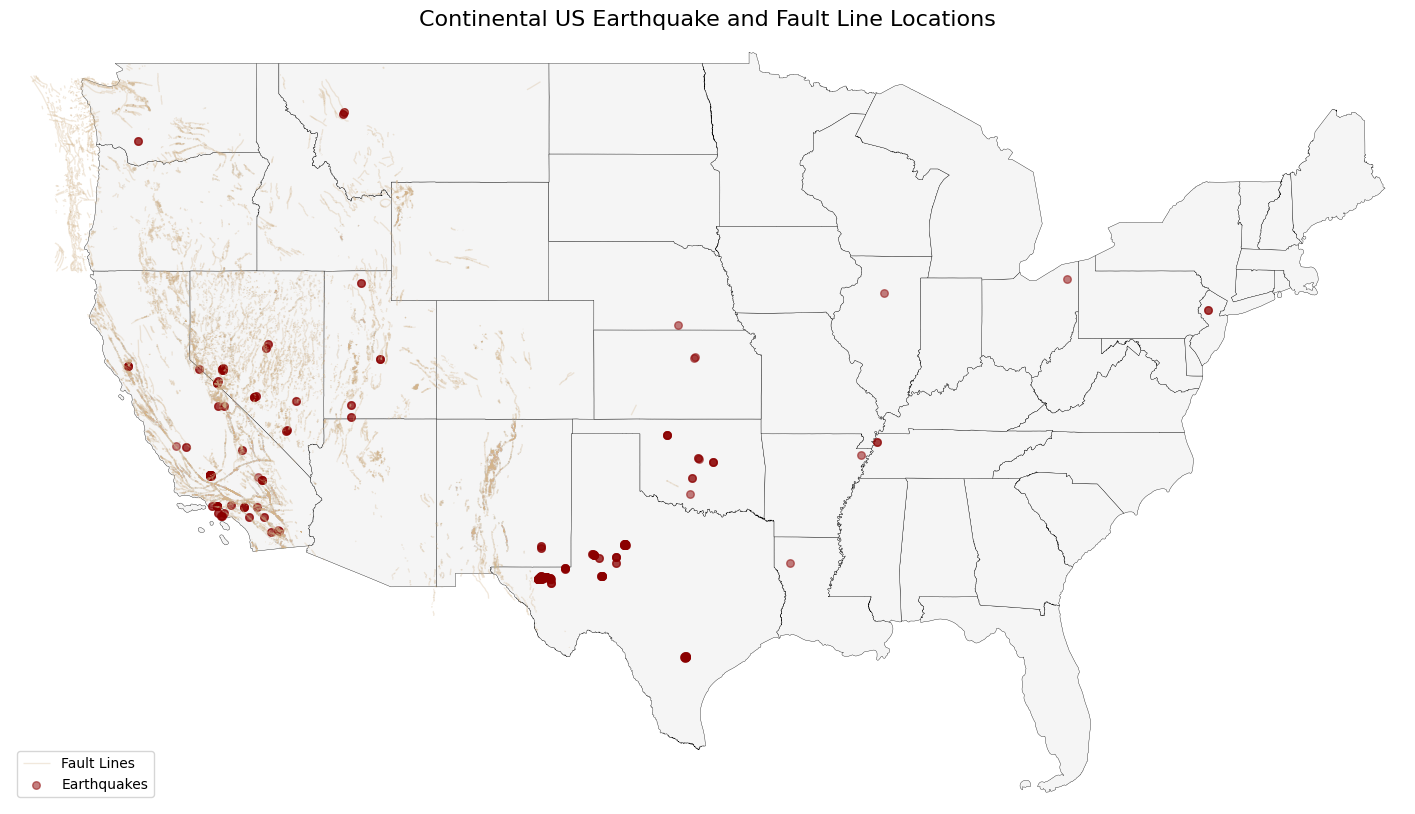

In [13]:
fig, ax = plt.subplots(figsize = (18, 10))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
faults.plot(ax = ax, color = 'tan', linewidth = 0.95, alpha = 0.3, label = 'Fault Lines')
usa.plot(ax = ax, color = 'darkred', markersize = 30, alpha = 0.5, label = 'Earthquakes')
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Continental US Earthquake and Fault Line Locations', fontsize = 16)
plt.xlim(-128, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.legend(loc = 'lower left')
plt.show()

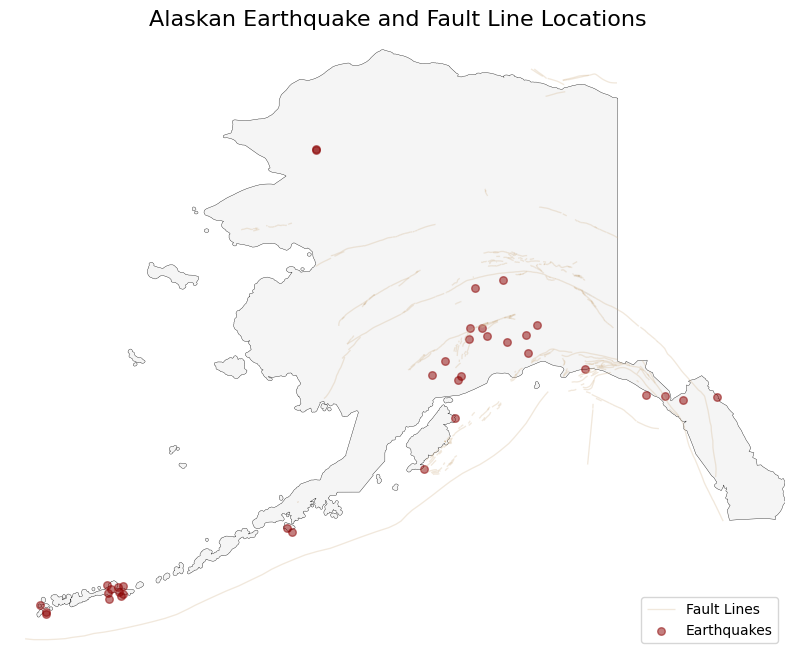

In [14]:
fig, ax = plt.subplots(figsize = (10, 8))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
faults.plot(ax = ax, color = 'tan', linewidth = 0.95, alpha = 0.3, label = 'Fault Lines')
usa.plot(ax = ax, color = 'darkred', markersize = 30, alpha = 0.5, label = 'Earthquakes')
ax.set_aspect('auto')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Alaskan Earthquake and Fault Line Locations', fontsize = 16)
plt.xlim(-181, -130)
plt.ylim(50, 72)
plt.xticks([])
plt.yticks([])
plt.legend(loc = 'lower right')
plt.show()

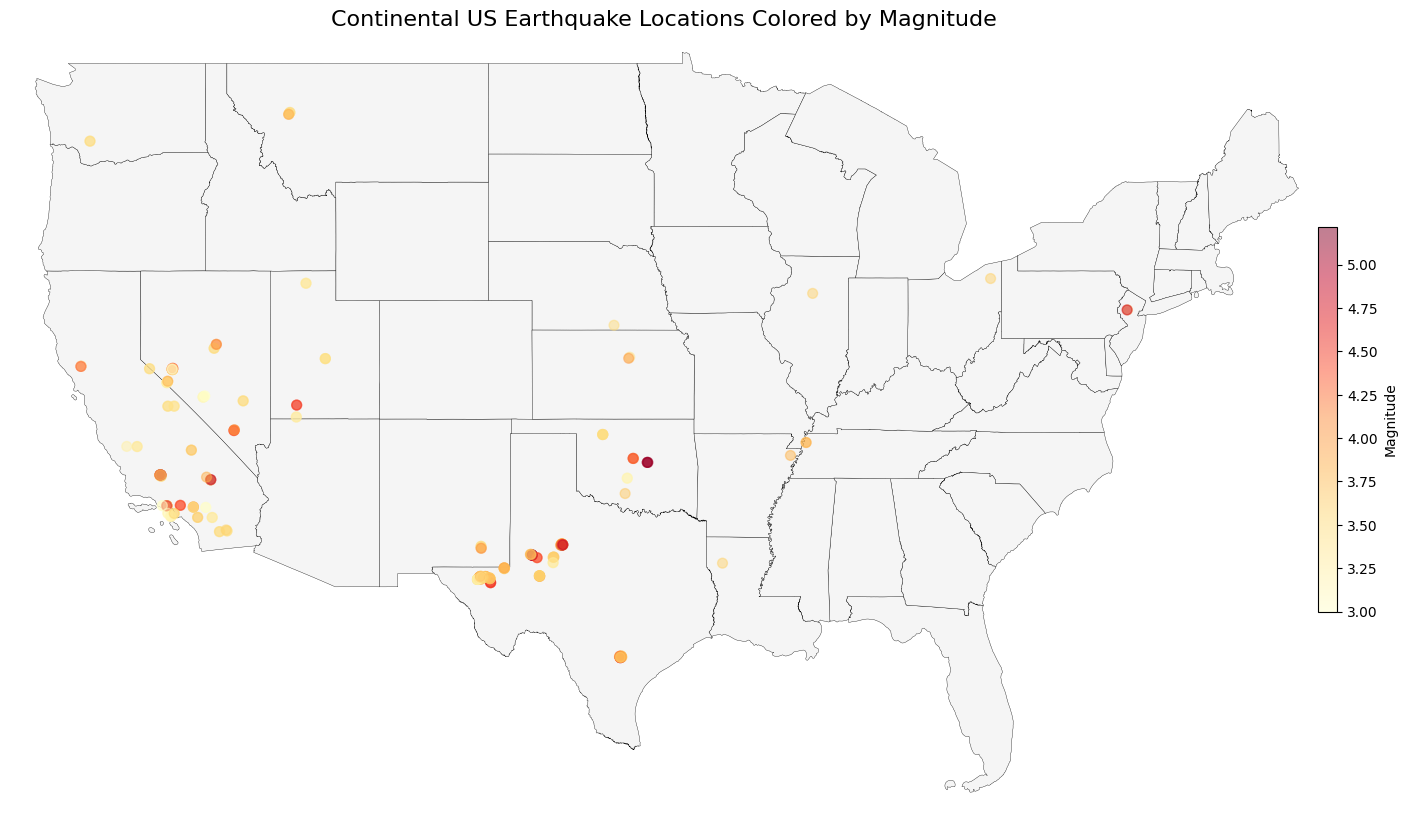

In [15]:
fig, ax = plt.subplots(figsize=(18, 10))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], c = usa['magnitude'], cmap = 'YlOrRd', s = 50, alpha = 0.5)
ax.set_aspect('auto')
cbar = fig.colorbar(scatter, ax = ax, shrink = 0.5, pad = 0.0002)
cbar.set_label('Magnitude')

plt.subplots_adjust(right = 0.98)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Continental US Earthquake Locations Colored by Magnitude', fontsize = 16)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.show()

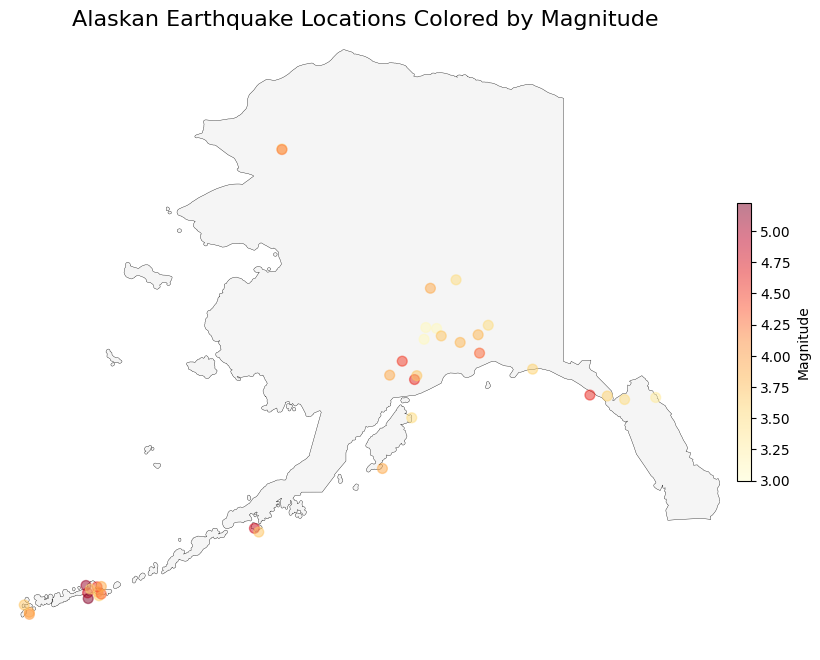

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], c = usa['magnitude'], cmap = 'YlOrRd', s = 50, alpha = 0.5)
ax.set_aspect('auto')
cbar = fig.colorbar(scatter, ax = ax, shrink = 0.45, pad = 0.02)
cbar.set_label('Magnitude')

plt.subplots_adjust(right = 0.98)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Alaskan Earthquake Locations Colored by Magnitude', fontsize = 16)
plt.xlim(-180, -130)
plt.ylim(50, 72)
plt.xticks([])
plt.yticks([])
plt.show()

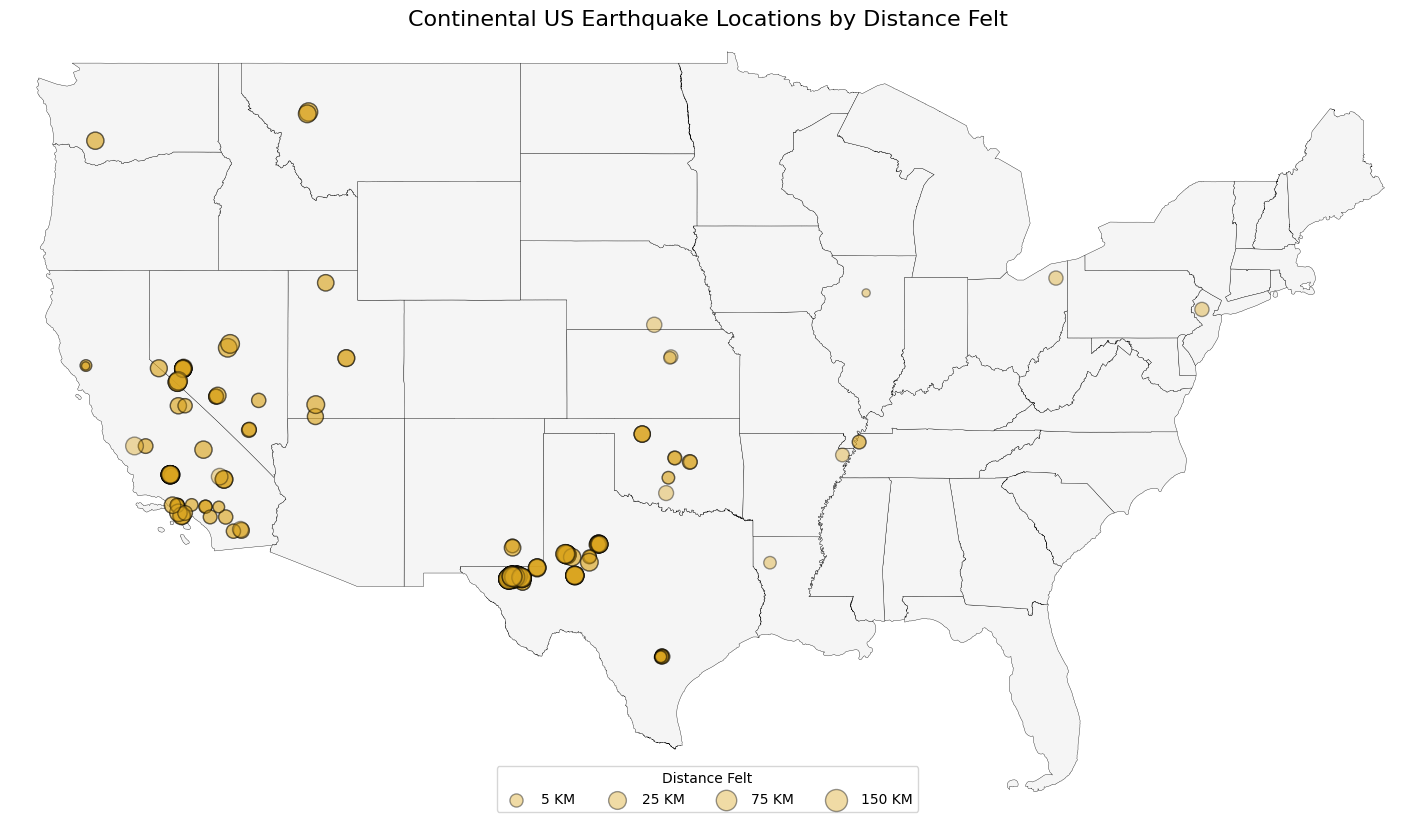

In [17]:
fig, ax = plt.subplots(figsize=(18, 10))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], color = 'goldenrod', edgecolor = 'black', s = np.log1p(usa['distanceKM']) * 50, alpha = 0.4)
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Continental US Earthquake Locations by Distance Felt', fontsize = 16)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])

sample_distances = [5, 25, 75, 150]
sample_sizes = np.log1p(sample_distances) * 50

for distance, size in zip(sample_distances, sample_sizes):
    ax.scatter([], [], s = size, label = f'{distance} KM', color = 'goldenrod', edgecolor = 'black', alpha = 0.4)

plt.legend(title = "Distance Felt", loc = 'lower center', bbox_to_anchor = (0.5, -0.02), ncol = 4)
plt.show()

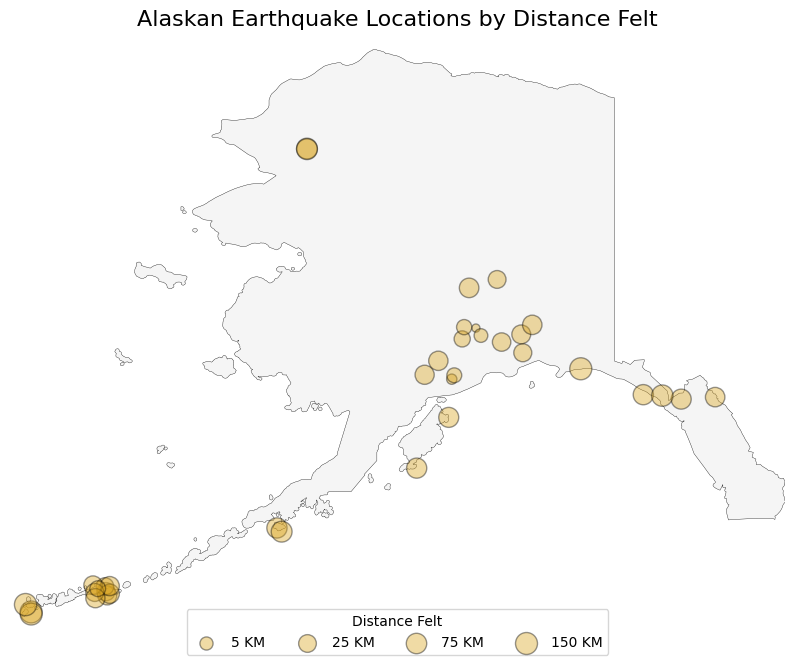

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], color = 'goldenrod', edgecolor = 'black', s = np.log1p(usa['distanceKM']) * 50, alpha = 0.4)
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Alaskan Earthquake Locations by Distance Felt', fontsize = 16)
plt.xlim(-180, -130)
plt.ylim(50, 72)
plt.xticks([])
plt.yticks([])

sample_distances = [5, 25, 75, 150]
sample_sizes = np.log1p(sample_distances) * 50

for distance, size in zip(sample_distances, sample_sizes):
    ax.scatter([], [], s = size, label = f'{distance} KM', color = 'goldenrod', edgecolor = 'black', alpha = 0.4)

plt.legend(title = "Distance Felt", loc = 'lower center', bbox_to_anchor = (0.5, -0.02), ncol = 4)
plt.show()

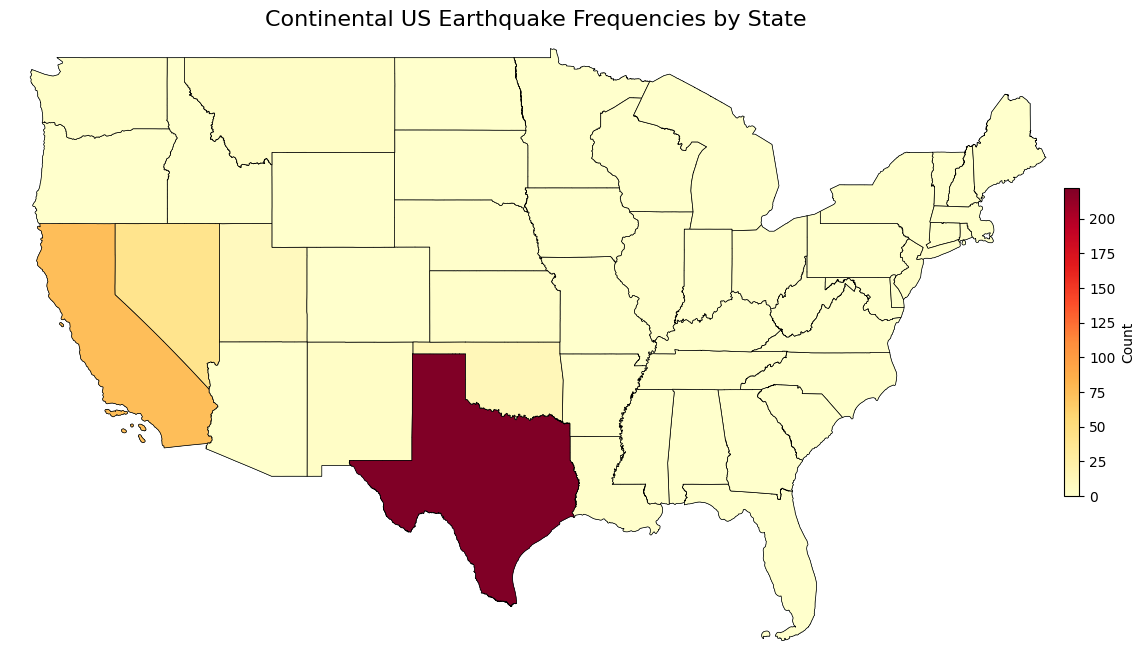

In [19]:
counts = merged['subnational'].value_counts().reset_index()
counts.columns = ['state', 'count']
state_counts = states.merge(counts, left_on = 'NAME', right_on ='state', how = 'left')
state_counts['count'] = state_counts['count'].fillna(0)

plt.figure(figsize=(16, 8))
ax = plt.gca()
state_counts.plot(ax = ax, linewidth = 0.2, edgecolor = 'black')
state_counts.plot(column = 'count', ax = plt.gca(), cmap = "YlOrRd", linewidth = 0.5, edgecolor = 'black')
cbar = plt.colorbar(ax.collections[1], ax = ax, shrink = 0.5, pad = 0.002)
cbar.set_label('Count')
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("Continental US Earthquake Frequencies by State", fontsize = 16)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.xlabel(None)
plt.ylabel(None)
plt.show()

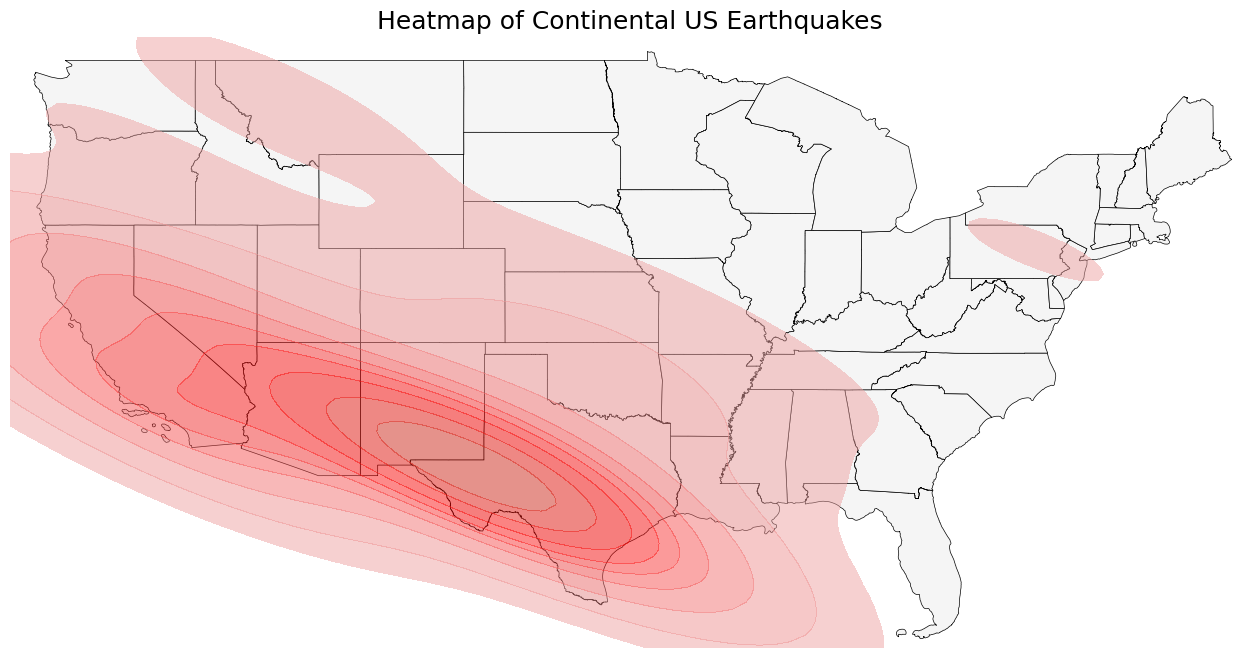

In [20]:
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize = (16,10))
custom_cmap = LinearSegmentedColormap.from_list("custom_reds", ["#EDA8A8", "#FF0000", "#CD3B2B"])
states.plot(ax = plt.gca(), linewidth = 0.5, edgecolor = 'black', color = 'whitesmoke')
sns.kdeplot(x = usa['longitude'], y = usa['latitude'], fill = True, cmap = custom_cmap, alpha = 0.5, levels = 10)
ax.set_aspect('auto')

plt.title("Heatmap of Continental US Earthquakes", fontsize = 18)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.xlabel(None)
plt.ylabel(None)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
    
plt.show()

## Tsunami Prediction: Logistic Regression, Random Forest Classifier, and XGBoost

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve, auc

#from xgboost import XGBClassifier

In [24]:
df.columns

Index(['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url',
       'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place',
       'distanceKM', 'placeOnly', 'location', 'continent', 'country',
       'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone',
       'locationDetails'],
      dtype='object')

In [30]:
num_cols = df.select_dtypes(include = ['int64', 'float64']).columns
num_cols

Index(['magnitude', 'time', 'updated', 'felt', 'cdi', 'mmi', 'tsunami', 'sig',
       'nst', 'dmin', 'rms', 'gap', 'depth', 'latitude', 'longitude',
       'distanceKM', 'postcode', 'timezone'],
      dtype='object')

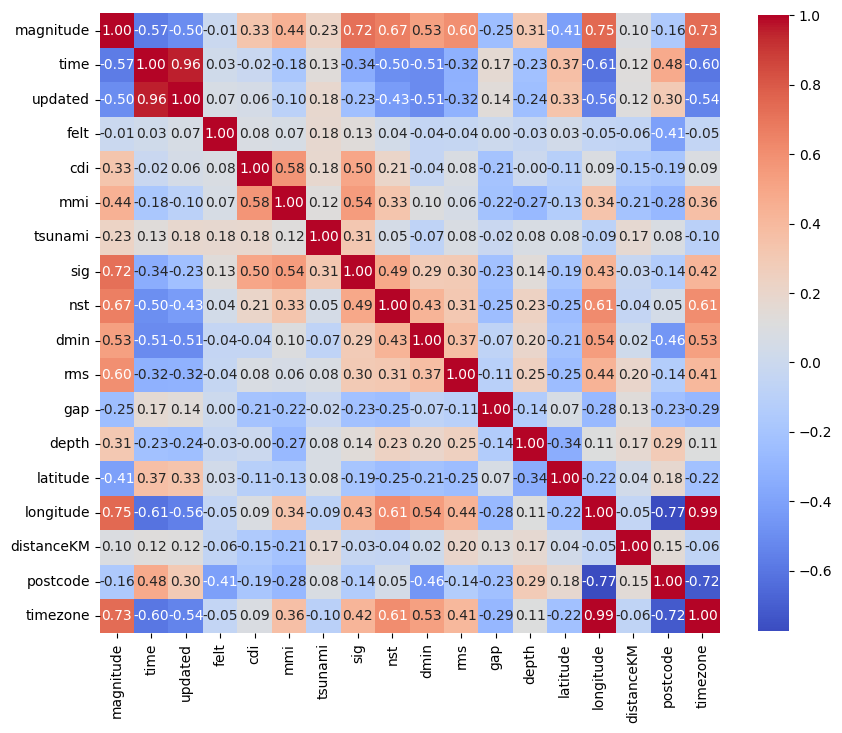

In [26]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize = (10,10))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', square = True, cbar_kws={"shrink": .8})

plt.show()